# Week 5: Hyperparameters and Model Validation

## Sources
- [Hyperparameter](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning))
- [Understanding the Bias-Variance Tradeoff](http://scott.fortmann-roe.com/docs/BiasVariance.html)
- [Model Tuning and the Bias-Variance Tradeoff](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Hyperparameter Optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization)

## Rob Pike's 5 Rules of Programming

These are the rules to know by heart when you are starting to write any code:

1. You can't tell where a program is going to spend its time. Bottlenecks occur in surprising places, so don't try to second guess and put in a speed hack until you've proven that's where the bottleneck is.
1. Measure. Don't tune for speed until you've measured, and even then don't unless one part of the code overwhelms the rest.
1. Fancy algorithms are slow when n is small, and n is usually small. Fancy algorithms have big constants. Until you know that n is frequently going to be big, don't get fancy. (Even if n does get big, use Rule 2 first.)
1. Fancy algorithms are buggier than simple ones, and they're much harder to implement. Use simple algorithms as well as simple data structures.
1. Data dominates. If you've chosen the right data structures and organized things well, the algorithms will almost always be self-evident. Data structures, not algorithms, are central to programming.

## Hyperparameters and Model Validation

Until today, we learnt the basic recipe for applying a supervised machine learning model:

1. Choose a class of model
1. Choose model hyperparameters
1. Fit the model to the training data
1. Use the model to predict labels for new data

The first two pieces of this—the choice of model and choice of hyperparameters—are perhaps the most important part of using these tools and techniques effectively. In order to make an informed choice, we need a way to validate that our model and our hyperparameters are a good fit to the data. While this may sound simple, there are some pitfalls that you must avoid to do this effectively.

In principle, model validation is very simple: after choosing a model and its hyperparameters, we can estimate how effective it is by applying it to some of the training data and comparing the prediction to the known value.

In [21]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn context and style.
sns.set_style('whitegrid')
sns.set_context('talk')

For this assignment, we will use breast cancer (diagnostic) dataset from University of Wisconsin.

In [53]:
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True)

print(f'There are {X.shape[0]:d} datapoints with {X.shape[1]:d} dimensions.')
print(f'{y.sum():d} of {X.shape[0]:d} are positive samples.')

There are 569 datapoints with 30 dimensions.
357 of 569 are positive samples.


### Q1. Fit a decision tree model using all of the dataset with default parameters and calculate the accuracy on the dataset.

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [52]:
clf = DecisionTreeClassifier()
clf.fit(X, y)
pred_train = clf.predict(X)

print("The accurancy of fitting into decision tree model is: {0:.2f}".format( 
      accuracy_score(pred_train, y)))

The accurancy of fitting into decision tree model is: 1.00


### Q2. In the question above, we tested our model in the wrong way. Using 3, 5, 7, 9-fold stratified cross-validations, calculate mean accuracy score and standard deviations for a decision tree model with default parameters.

In [46]:
from sklearn.model_selection import StratifiedKFold

In [47]:
for num in [3, 5, 7, 9]:

    skf = StratifiedKFold(n_splits = num)

    acs_k = []
    for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf = DecisionTreeClassifier()
        clf.fit(X_train, y_train)
        pred_test = clf.predict(X_test)
        acs_k.append(accuracy_score(pred_test, y_test))

    print(f"For k={num}, the accuracy is: {np.mean(acs_k):.2%} +- {np.std(acs_k):.2%}")

For k=3, the accuracy is: 89.98% +- 3.04%
For k=5, the accuracy is: 92.62% +- 2.46%
For k=7, the accuracy is: 93.68% +- 3.73%
For k=9, the accuracy is: 93.87% +- 3.56%


### Q3. Using k for the minimum cross-validation standard deviation from the question above, you will find the best value for the ```max_depth``` parameter. You should try ```max_depth``` between 1 and ```n_features```. Plot both mean training accuracy and mean test accuracy against ```max_depth```. Describe how both accuracies behave with respect to ```max_depth```.

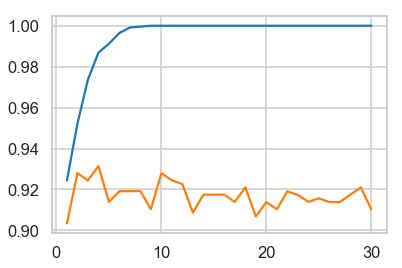

In [48]:
max_depths = np.arange(1, X.shape[1] + 1)
acs_mean_train = []
acs_mean_test = []

for max_depth in max_depths:

    skf = StratifiedKFold(n_splits=5)
    
    acs_train = []
    acs_test = []
    for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf = DecisionTreeClassifier(max_depth = max_depth)
        clf.fit(X_train, y_train)
        pred_train = clf.predict(X_train)
        pred_test = clf.predict(X_test)
        
        acs_train.append(accuracy_score(y_train, pred_train))
        acs_test.append(accuracy_score(y_test, pred_test))
        
    acs_mean_train.append(np.mean(acs_train))
    acs_mean_test.append(np.mean(acs_test))
    
sns.lineplot(max_depths, acs_mean_train)
sns.lineplot(max_depths, acs_mean_test)

This test is trying to tell us that we are not going to use the training accuracy when we are testing the model. In general, we always ignore training accuracy completely. It is not telling us anything useful. In this code, we are going to get the best value of parameter **max_depth** by running cross validation. 

For example, a K-NN model with k=1 will always deliver 100% accuracy on the training data set. But this does not mean that it can classify **anything** correctly on any non-training data point. 

When we are using training accuracy, we can see that the plot above shows the best value of parameter **max_depth** is around 8 and the best value of parameter **max_depth** is around 2 when we are doing testing accuracy.

**Overfitting** means that it learned rules specifically for the train set. We will never ever use training set to test our model.

### Q4. In the previous question, you saw that the training error and test error behave differently. When evaluating models, always use test error. Now, you will optimize for two parameters at the same time using GridSearchCV using the same k value. Find the values for ```max_depth``` and ```max_features``` that gives the best accuracy score. (Hint: Both parameters can take values between 1 and ```n_features```.)

In [49]:
from sklearn.model_selection import GridSearchCV

In [50]:
max_depths = np.arange(1, X.shape[1] + 1)

param_grid = {'max_depth': max_depths,
              'max_features': max_depths}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5, scoring= "accuracy")
grid.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]), 'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [51]:
print("The best values for paramaters:", grid.best_params_)
print("The best score:", round(grid.best_score_,2))

The best values for paramaters: {'max_depth': 4, 'max_features': 4}
The best score: 0.95


### Q5. In this question, you are going to repeat the same method as in Q3 with a regularized linear regression model (ElasticNet) on ```alpha``` parameter for 60 values between $10^{-5}$ and 10. Use a regression dataset given below, k = 5 for cross-validation and the coefficient of determination R2 for model scoring. (Hint: you may need to use plt.semilogx for plotting scores against alpha.)

In [34]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

coef = np.random.randn(500)
coef[50:] = 0.0
X = np.random.randn(250, 500)
y = np.dot(X, coef)

print(f'There are {X.shape[0]:d} datapoints with {X.shape[1]:d} dimensions.')
print(f'y is between {y.min()} and {y.max()}')

alphas = np.logspace(-5, 1, 60)

There are 250 datapoints with 500 dimensions.
y is between -21.28716541632624 and 17.185832708654747


/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarni

/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarni

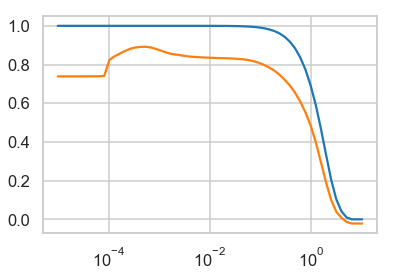

In [35]:
r2s_mean_train = []
r2s_mean_test = []

for alpha in alphas:

    kf = KFold(n_splits=5)
    
    r2s_train = []
    r2s_test = []
    for train_index, test_index in kf.split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        regression = ElasticNet(alpha = alpha)
        regression.fit(X_train, y_train)
        pred_train = regression.predict(X_train)
        pred_test = regression.predict(X_test)
        
        r2s_train.append(r2_score(y_train, pred_train))
        r2s_test.append(r2_score(y_test, pred_test))
        
    r2s_mean_train.append(np.mean(r2s_train))    
    r2s_mean_test.append(np.mean(r2s_test))

plt.semilogx(alphas, r2s_mean_train)
plt.semilogx(alphas, r2s_mean_test)

It looks like the best **alpha** is around 10 power minus 3. When the value is closer to 10 power 0, the R-squared decreases.

### Q6. Similar to Q4, optimize ElasticNet for two parameters at the same time: ```alpha``` and ```l1_ratio``` with k=5.

In [38]:
alphas = np.logspace(-5, 1, 10)
l1_ratios = np.linspace(0, 1, 10)

In [39]:
param_grid = {'alpha': alphas,
              'l1_ratio': l1_ratios}

grid = GridSearchCV(ElasticNet(), param_grid, cv = 5, scoring= "r2")
grid.fit(X,y)

/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarni

/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarni

/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarni

/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jason639782/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarni

GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.00000e-05, 4.64159e-05, 2.15443e-04, 1.00000e-03, 4.64159e-03,
       2.15443e-02, 1.00000e-01, 4.64159e-01, 2.15443e+00, 1.00000e+01]), 'l1_ratio': array([0.     , 0.11111, 0.22222, 0.33333, 0.44444, 0.55556, 0.66667,
       0.77778, 0.88889, 1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [41]:
print("When k=5:")
print("The best values for params:", grid.best_params_)
print("The R-squared:", round(grid.best_score_,2))

When k=5:
The best values for params: {'alpha': 0.001, 'l1_ratio': 1.0}
The R-squared: 1.0
